In [1]:
import os
import pandas as pd
from PIL import Image
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import transforms, models
from torch.utils.data import DataLoader
from tqdm import tqdm

# Define a custom Dataset for loading images and their targets from a DataFrame
class PaperclipsDataset(Dataset):
    def __init__(self, csv_file=None, df=None, images_dir=None, transform=None, is_train=True):
        """
        Either csv_file or df must be provided.
        :param csv_file: Path to CSV file.
        :param df: Pre-loaded DataFrame.
        :param images_dir: Directory where images are stored.
        :param transform: torchvision transforms to be applied on the images.
        :param is_train: If True, expects a 'clip_count' column for targets.
        """
        if df is not None:
            self.data = df.reset_index(drop=True)
        elif csv_file is not None:
            self.data = pd.read_csv(csv_file)
        else:
            raise ValueError("Either csv_file or df must be provided.")
            
        self.images_dir = images_dir
        self.transform = transform
        self.is_train = is_train
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        image_id = row['id']
        # Assuming images are stored as "<id>.jpg" in the images_dir
        image_path = os.path.join(self.images_dir, f"clips-{image_id}.jpg")
        image = Image.open(image_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
            
        if self.is_train:
            target = row['clip_count']
            # Wrap target in a tensor (regression target as float)
            target = torch.tensor([target], dtype=torch.float32)
            return image, target
        else:
            # For test, return the image and its id
            return image, image_id


In [2]:
import os
import pandas as pd

# Paths to CSV files and image subdirectory
train_path = "train.csv"
test_path = "test.csv"
images_subdir = "paperclips"

# Load the train and test CSV files
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

# Split train into training and validation sets (90% for training)
train_pct = 0.9
df_train = train_df.sample(frac=train_pct, random_state=0)
df_validate = train_df.drop(df_train.index)

print(f"Training size: {len(df_train)}")
print(f"Validate size: {len(df_validate)}")

# priunt head of train test and val
print(df_train.head())
print(df_validate.head())
print(test_df.head())


from tqdm import tqdm  # Import tqdm for progress bars


Training size: 18000
Validate size: 2000
          id  clip_count
19134  49135          65
4981   34982          44
16643  46644          27
19117  49118          59
5306   35307          66
       id  clip_count
43  30044           3
52  30053          18
55  30056           5
62  30063          55
63  30064          34
      id
0  25001
1  25002
2  25003
3  25004
4  25005


In [3]:
from tqdm import tqdm  # Import tqdm for progress bars

# Define image transforms (using a higher resolution for better feature extraction)
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Create Dataset objects (assuming PaperclipsDataset is defined)
train_dataset = PaperclipsDataset(df=df_train, images_dir=images_subdir, transform=train_transform, is_train=True)
val_dataset = PaperclipsDataset(df=df_validate, images_dir=images_subdir, transform=val_transform, is_train=True)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Define a model using a pretrained ResNet-18
class ResNetGaussian(nn.Module):
    def __init__(self):
        super(ResNetGaussian, self).__init__()
        # Load a pretrained ResNet-18 model
        self.base = models.resnet18(pretrained=True)
        # Remove the final fully connected layer
        num_features = self.base.fc.in_features
        self.base.fc = nn.Identity()
        # Add new fully connected layers for predicting mean and log variance
        self.fc = nn.Sequential(
            nn.Linear(num_features, 128),
            nn.ReLU(),
            nn.Linear(128, 2)  # Two outputs: mean and log variance
        )
        
    def forward(self, x):
        features = self.base(x)
        x = self.fc(features)
        mean = x[:, 0:1]
        log_var = x[:, 1:2]
        std = torch.exp(0.5 * log_var)  # Calculate standard deviation
        return mean, std, log_var

# Set device, instantiate the model, define loss and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNetGaussian().to(device)

def gaussian_nll_loss(mean, log_var, target):
    loss = 0.5 * torch.exp(-log_var) * (target - mean)**2 + 0.5 * log_var
    return torch.mean(loss)


# Set device, instantiate the model, define optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNetGaussian().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
print("device:", device)

def gaussian_nll_loss(mean, log_var, target):
    # Calculate the loss for each instance
    loss = 0.5 * torch.exp(-log_var) * (target - mean)**2 + 0.5 * log_var
    # Return the average loss over the batch
    return torch.mean(loss)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    train_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]")
    for images, targets in train_bar:
        images, targets = images.to(device), targets.to(device)
        optimizer.zero_grad()
        mean, std, log_var = model(images)
        loss = gaussian_nll_loss(mean, log_var, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        train_bar.set_postfix(loss=loss.item())
    
    train_loss = running_loss / len(train_loader.dataset)
    
    # Validation loop
    model.eval()
    val_loss = 0.0
    val_bar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validate]")
    with torch.no_grad():
        for images, targets in val_bar:
            images, targets = images.to(device), targets.to(device)
            mean, std, log_var = model(images)
            loss = gaussian_nll_loss(mean, log_var, targets)
            val_loss += loss.item() * images.size(0)
            val_bar.set_postfix(loss=loss.item())
    val_loss /= len(val_loader.dataset)
    
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

# Create test dataset (for which we do not have targets)
test_dataset = PaperclipsDataset(csv_file=test_path, images_dir=images_subdir, transform=val_transform, is_train=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Run model on test set to generate predictions
model.eval()
predictions = []
stds = []
image_ids = []
test_bar = tqdm(test_loader, desc="Testing")
with torch.no_grad():
    for images, ids in test_bar:
        images = images.to(device)
        mean, std, log_var = model(images)
        predictions.extend(mean.cpu().numpy())
        stds.extend(std.cpu().numpy())
        image_ids.extend(ids)

# Save predictions to a DataFrame and display the first few rows
test_results = pd.DataFrame({
    'id': image_ids,
    'clip_count': [pred[0] for pred in predictions],
    'std': [s[0] for s in stds]
})
print(test_results.head())


c:\Users\aqjsh\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\aqjsh\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\aqjsh/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 46.2MB/s]


device: cuda


Epoch 1/10 [Validate]: 100%|██████████| 63/63 [00:05<00:00, 12.11it/s, loss=3.83]


Epoch 1/10, Training Loss: 16.4945, Validation Loss: 3.5916


Epoch 2/10 [Validate]: 100%|██████████| 63/63 [00:05<00:00, 12.19it/s, loss=3.54]


Epoch 2/10, Training Loss: 3.6139, Validation Loss: 3.2644


Epoch 3/10 [Validate]: 100%|██████████| 63/63 [00:05<00:00, 12.22it/s, loss=3.09]


Epoch 3/10, Training Loss: 3.1683, Validation Loss: 2.5661


Epoch 4/10 [Validate]: 100%|██████████| 63/63 [00:05<00:00, 12.43it/s, loss=1.81]


Epoch 4/10, Training Loss: 2.2902, Validation Loss: 1.4567


Epoch 5/10 [Validate]: 100%|██████████| 63/63 [00:05<00:00, 12.22it/s, loss=1.77] 


Epoch 5/10, Training Loss: 1.4542, Validation Loss: 1.3203


Epoch 6/10 [Validate]: 100%|██████████| 63/63 [00:05<00:00, 12.42it/s, loss=1.12]


Epoch 6/10, Training Loss: 1.1777, Validation Loss: 1.6488


Epoch 7/10 [Validate]: 100%|██████████| 63/63 [00:05<00:00, 11.87it/s, loss=1.09] 


Epoch 7/10, Training Loss: 1.0264, Validation Loss: 0.8190


Epoch 8/10 [Validate]: 100%|██████████| 63/63 [00:04<00:00, 12.69it/s, loss=0.776]


Epoch 8/10, Training Loss: 0.9633, Validation Loss: 0.8059


Epoch 9/10 [Validate]: 100%|██████████| 63/63 [00:04<00:00, 12.81it/s, loss=0.753]


Epoch 9/10, Training Loss: 0.8756, Validation Loss: 0.7004


Epoch 10/10 [Validate]: 100%|██████████| 63/63 [00:05<00:00, 11.54it/s, loss=0.644]


Epoch 10/10, Training Loss: 0.8069, Validation Loss: 0.6056


Testing: 100%|██████████| 157/157 [00:13<00:00, 11.28it/s]

              id  clip_count       std
0  tensor(25001)    2.483635  0.267554
1  tensor(25002)   48.473743  1.757442
2  tensor(25003)   63.928703  2.566376
3  tensor(25004)    2.864473  0.326064
4  tensor(25005)   45.538761  1.660115


In [4]:
# save model to current directory
torch.save(model.state_dict(), 'model.pth')
print("Model saved to model.pth")


Model saved to model.pth


In [5]:
# do predictions on all test data, save to csv
test_results.to_csv('test_results.csv', index=False)
print("Test results saved to test_results.csv")

# Paths to CSV files and image subdirectory
train_path = "train.csv"
test_path = "test.csv"
images_subdir = "paperclips"


Test results saved to test_results.csv


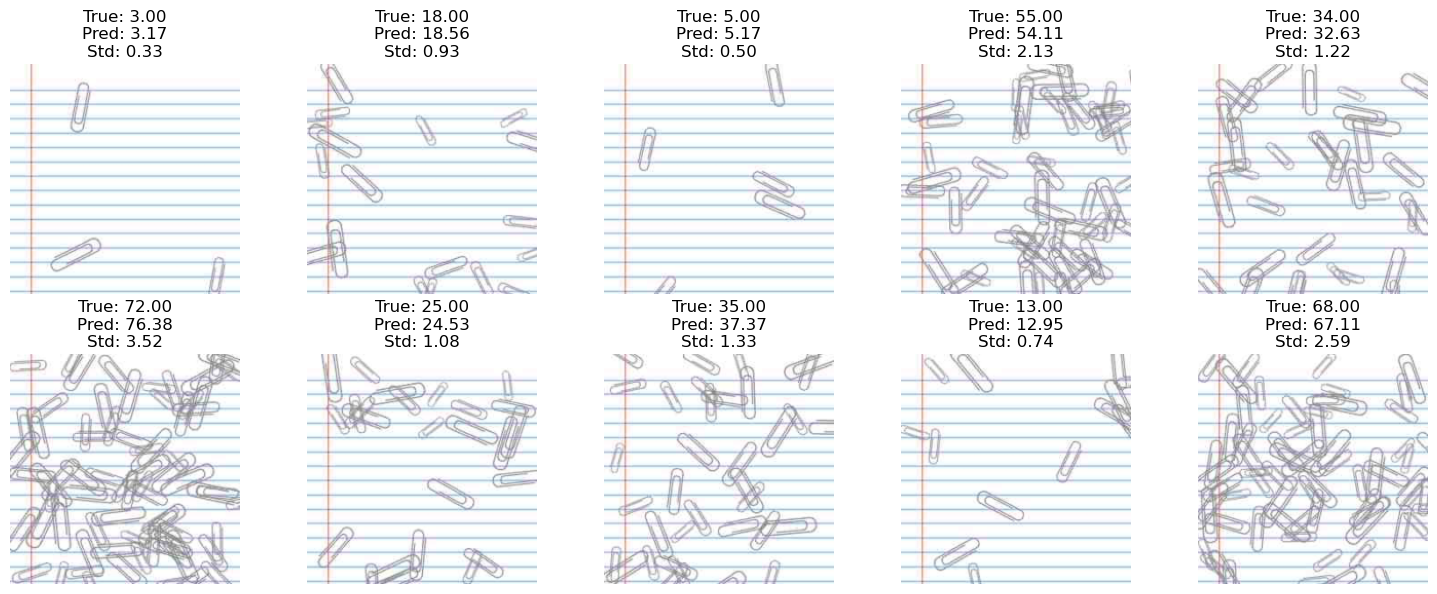

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Set the model to evaluation mode
model.eval()

# Create a list to store a few examples from the validation set
val_examples = []

# Get a few samples from the validation loader (e.g., 10 examples)
with torch.no_grad():
    for images, targets in val_loader:
        images = images.to(device)
        mean, std, _ = model(images)
        # Move tensors to CPU and iterate through the batch
        for img, target, pred_mean, pred_std in zip(images.cpu(), targets.cpu(), mean.cpu(), std.cpu()):
            val_examples.append((img, target.item(), pred_mean.item(), pred_std.item()))
        # Break after collecting enough examples (adjust number as needed)
        if len(val_examples) >= 10:
            break

# Define number of examples to display (e.g., 10)
num_examples = min(40, len(val_examples))

# Create a subplot grid
fig, axes = plt.subplots(nrows=5, ncols=8, figsize=(15, 6))
axes = axes.flatten()

for ax, (img, true_val, pred_mean, pred_std) in zip(axes, val_examples[:num_examples]):
    # Convert the tensor image to a NumPy array
    # Assuming the image is in [C, H, W] format, convert to [H, W, C]
    img_np = np.transpose(img.numpy(), (1, 2, 0))
    
    # If the images were normalized during preprocessing, you might need to denormalize them here.
    
    ax.imshow(img_np)
    ax.set_title(f"True: {true_val:.2f}\nPred: {pred_mean:.2f}\nStd: {pred_std:.2f}")
    ax.axis('off')

plt.tight_layout()
plt.show()
